In [15]:
## import libraries
import sys
import glob
import re
import textwrap

import geopandas as gpd
import cartopy
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import cmocean.cm as cmo
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.patheffects as pe
import matplotlib.ticker as mticker

# cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap, plot_terrain
from utils import roundPartial, select_months_ds
import customcmaps as ccmap

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## load continental divide shapefile
fp = path_to_data + 'downloads/continental_divide_shapefile/pw312bv3382.shp'
divide = gpd.read_file(fp, crs="ESPG:4326")

## load HU2 shapefile for regions 10, 11, 13, 14
region_lst = [10, 11, 13, 14]
WBD_lst = []
for i, region in enumerate(region_lst):
    fp = path_to_data + 'downloads/WBD_HU2_{0}/Shape/WBDHU2.shp'.format(region)
    WBD = gpd.read_file(fp, crs="ESPG:4326")
    WBD_lst.append(WBD)

## load watershed shapefile
## use geopandas to import the shapefile
fp = path_to_data + 'downloads/CO_HUC8/wbdhu8.shp'
polys = gpd.read_file(fp, crs="epsg:4326") # have to manually set the projection

In [4]:
HUC8_ID_lst = ['14050001', '13010001', '10190002', '11020001']
HUC8_lbl_lst = ['Upper Yampa', 'Rio Grande Headwaters', 'Upper South Platte', 'Arkansas Headwaters']
lbl_align = ['right', 'right', 'left', 'left']
polys_lst = []
for i, HUC8_ID in enumerate(HUC8_ID_lst):
    idx = (polys.HUC8 == str(HUC8_ID_lst[i]))
    tmp =  polys[idx]
    polys_lst.append(tmp)

In [5]:
fname = path_to_data + 'preprocessed/PRISM/PRISM_HUC8_CO_sp.nc'
PRISM = xr.open_dataset(fname)
PRISM = PRISM.sel(HUC8=HUC8_ID_lst)
ys = PRISM.lat.values
xs = PRISM.lon.values

In [6]:
## load Rutz AR frequency data
fname = path_to_data + 'MERRA2_Rutz_AR_count.nc'
ar = xr.open_dataset(fname)

## load AR scale frequency data 
fname = path_to_data + 'ERA5_ARScale_count.nc'
arscale = xr.open_dataset(fname)

## Load tARgetv4 AR frequency data
fname = path_to_data + 'tARgetv4_count.nc'
tARgetv4 = xr.open_dataset(fname)

data_lst = [tARgetv4, arscale, ar]

In [7]:
# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

# Set tick/grid locations
ext1 = [-111., -100., 35.5, 42.5] # extent of CO
dx = np.arange(ext1[0],ext1[1]+2,2)
dy = np.arange(ext1[2]-.5,ext1[3]+1,1)
letter_lst = list(map(chr, range(97, 123)))
lbl_lst = ['tARgetv4', 'AR Scale', 'Rutz AR']
varname_lst = ['kidmap', 'rank', 'AR']

lbl_dict = {'Colorado': (-109., 39.),
            'Arkansas': (-102., 36.5),
            'Rio Grande': (-107., 36.),
            'South Platte': (-103., 41.5)
    }

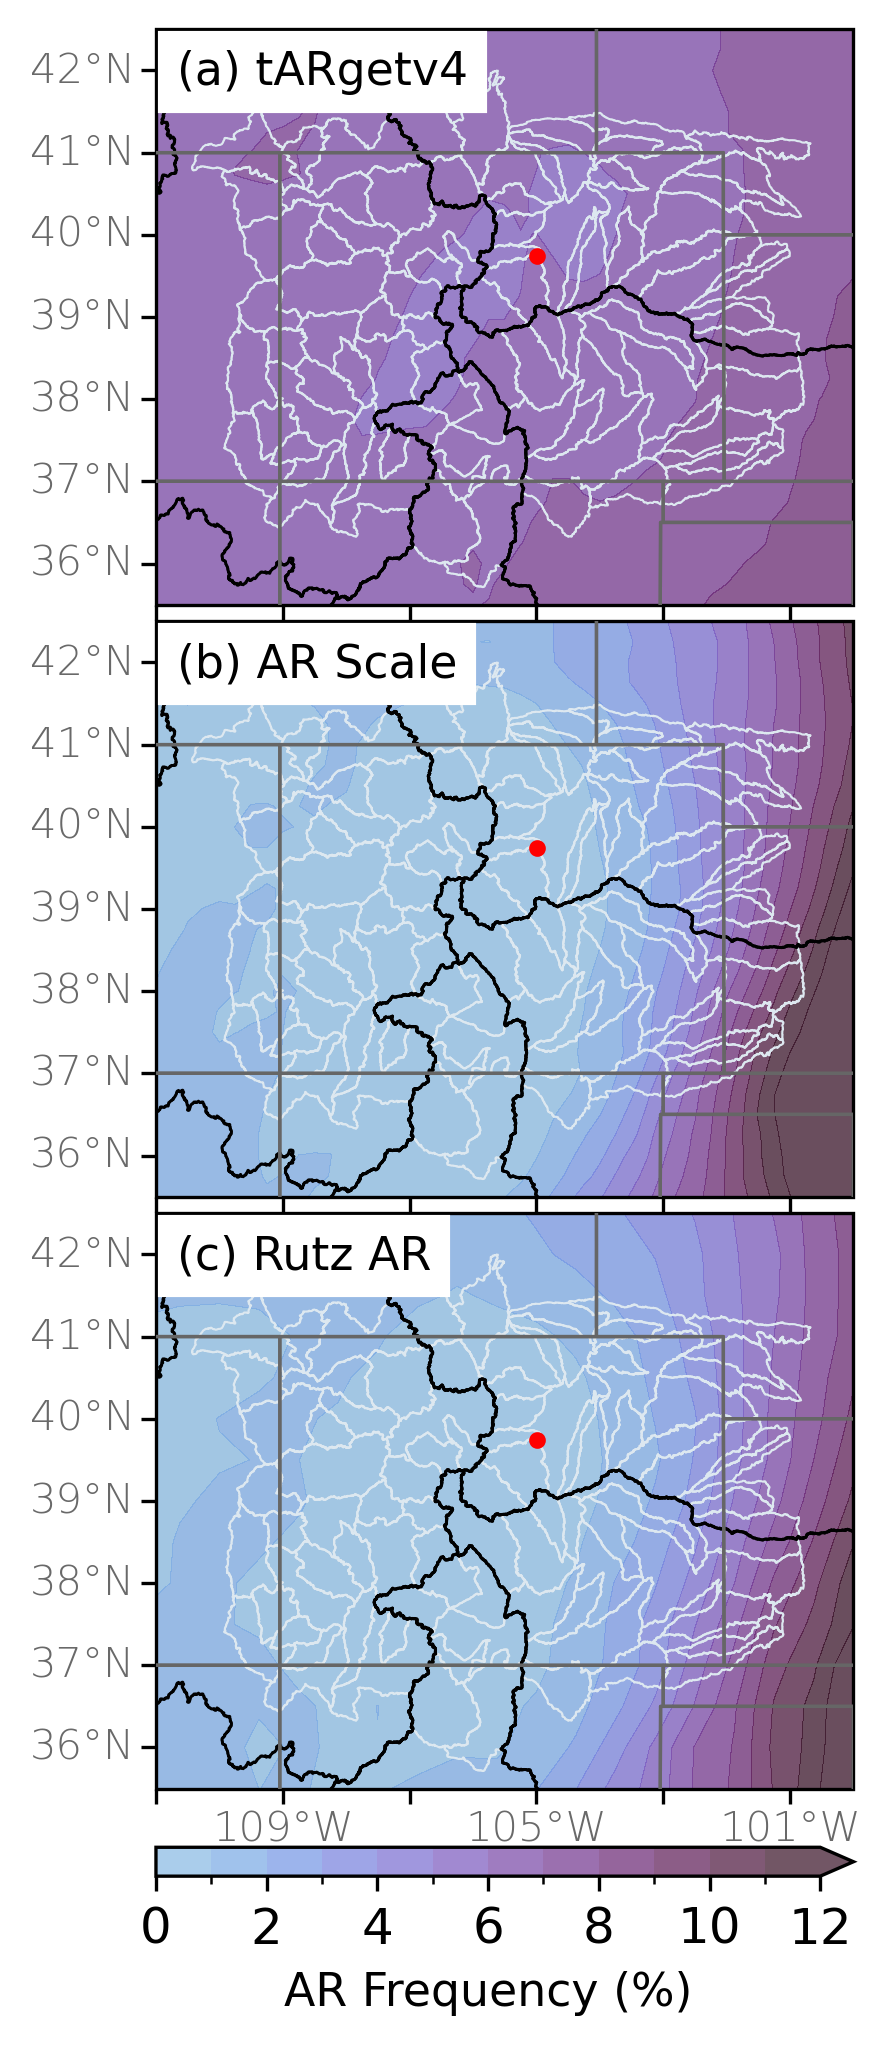

In [18]:
# Create figure
fig = plt.figure(figsize=(3, 8))
fig.dpi = 300
fname = path_to_figs + 'ar_freq_overhead'
fmt = 'png'

nrows = 5
ncols = 1

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 1, 0.05, 0.05], width_ratios = [1], wspace=0.02, hspace=0.04)
## use gs[rows index, columns index] to access grids

b_lons = [False, False, True]

for k, data in enumerate(data_lst):
    ## Add axis for plot
    ax = fig.add_subplot(gs[k,0], projection=mapcrs)
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy,left_lats=True, 
                      right_lats=False, bottom_lons=b_lons[k], mask_ocean=False, coastline=False)

    # add choropleth watershed fraction
    # data = data[varname_lst[k]].values
    data_mask = data[varname_lst[k]].where((data[varname_lst[k]] != 0)).values
    cmap = cmo.tools.crop_by_percent(cmo.dense, 25, which='min', N=None)
    cflevs = np.arange(0, 13, 1)
    cmap, norm, bnds = ccmap.cmap_segmented(cmap, cflevs)
    cf = ax.contourf(data.lon.values, data.lat.values, data_mask, transform=datacrs,
                     levels=bnds, norm=norm, 
                     cmap=cmap, 
                     alpha=0.7, extend='max')

    ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8, zorder=199)
    # Plot Location of pts
    ax.plot(-104.9903, 39.7392, 'ro', markersize=3, transform=datacrs, zorder=201)

    ## add in CO subbasins
    polys.plot(ax=ax, edgecolor='#dde8f0', color='None', linewidth=0.5, zorder=98)
    # tmp.plot(ax=ax, edgecolor='white', color='None', zorder=99)
    # # basin.plot(ax=ax, edgecolor='white', color='None', zorder=99)

    ## add in region watershed shape
    for j, WBD in enumerate(WBD_lst):
        WBD.plot(ax=ax, edgecolor='k', color='None', linewidth=0.7, zorder=100)

    # ## add continental divide
    # # divide.plot(ax=ax, color='tab:blue', zorder=99)

    # # ax.set_title(lbl_lst[k], loc='left', fontsize=14)
    # ax.text(-0.16, 0.5, lbl_lst[k], va='bottom', ha='center',
    #                 rotation='vertical', rotation_mode='anchor', fontsize=13,
    #                 transform=ax.transAxes)

    titlestring = '({0}) {1}'.format(letter_lst[k], lbl_lst[k])
    ax.text(0.03, 0.965, titlestring, ha='left', va='top', transform=ax.transAxes, 
            fontsize=11., backgroundcolor='white', zorder=500)

# Add color bar
cbax = plt.subplot(gs[-1,0]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
cb.set_label('AR Frequency (%)', fontsize=11)
cb.ax.tick_params(labelsize=12)
        
fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()